In [1]:
import copick
import matplotlib.pyplot as plt
import numpy as np

from copick_utils.segmentation import segmentation_from_picks
from tqdm.auto import tqdm

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG_PATH = "/kaggle/working/copick_10441.config"
RESOLUTION = 2
SESSION_ID = "0"
TOMO_TYPE = "wbp" 
USER_ID = "curation"
VOXEL_SIZE =  10
VOXEL_SPACING = VOXEL_SIZE *  (2**RESOLUTION)

In [3]:
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",
    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "identifier": "GO:0070288",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "identifier": "UniProtKB:P10537",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "identifier": "UniProtKB:P00722",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "identifier": "GO:0022626",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "identifier": "UniProtKB:P01267",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "identifier": "GO:0170047",
            "is_particle": true,
            "pdb_id": "6N4V",            
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],
    "overlay_root": "./kaggle/working/portal/overlay/",
    "static_root": "./10441/",
    "overlay_fs_args": {
        "auto_mkdir": true
    }
}"""
with open(CONFIG_PATH, "w") as f:
    f.write(config_blob)

In [4]:
root = copick.from_file(CONFIG_PATH)

In [5]:
data_dicts = []
for run in tqdm(root.runs):
    tomogram = run.get_voxel_spacing(VOXEL_SIZE).get_tomogram(TOMO_TYPE).numpy(str(RESOLUTION))
    segmentation = np.zeros(tomogram.shape)
    for obj in root.pickable_objects:
        if not obj.is_particle:
            continue
        pick = run.get_picks(object_name=obj.name, user_id=USER_ID)
        if len(pick):
            segmentation = segmentation_from_picks.from_picks(
                    pick[0], segmentation, obj.radius, obj.label, voxel_spacing=VOXEL_SPACING)
            segmentation = (segmentation > 0).astype(int)
    data_dicts.append({"image": tomogram, "label": segmentation.astype("uint8")})

100%|██████████| 27/27 [00:02<00:00, 13.02it/s]


In [6]:
tomogram = data_dicts[0]["image"]
mask = data_dicts[0]["label"]

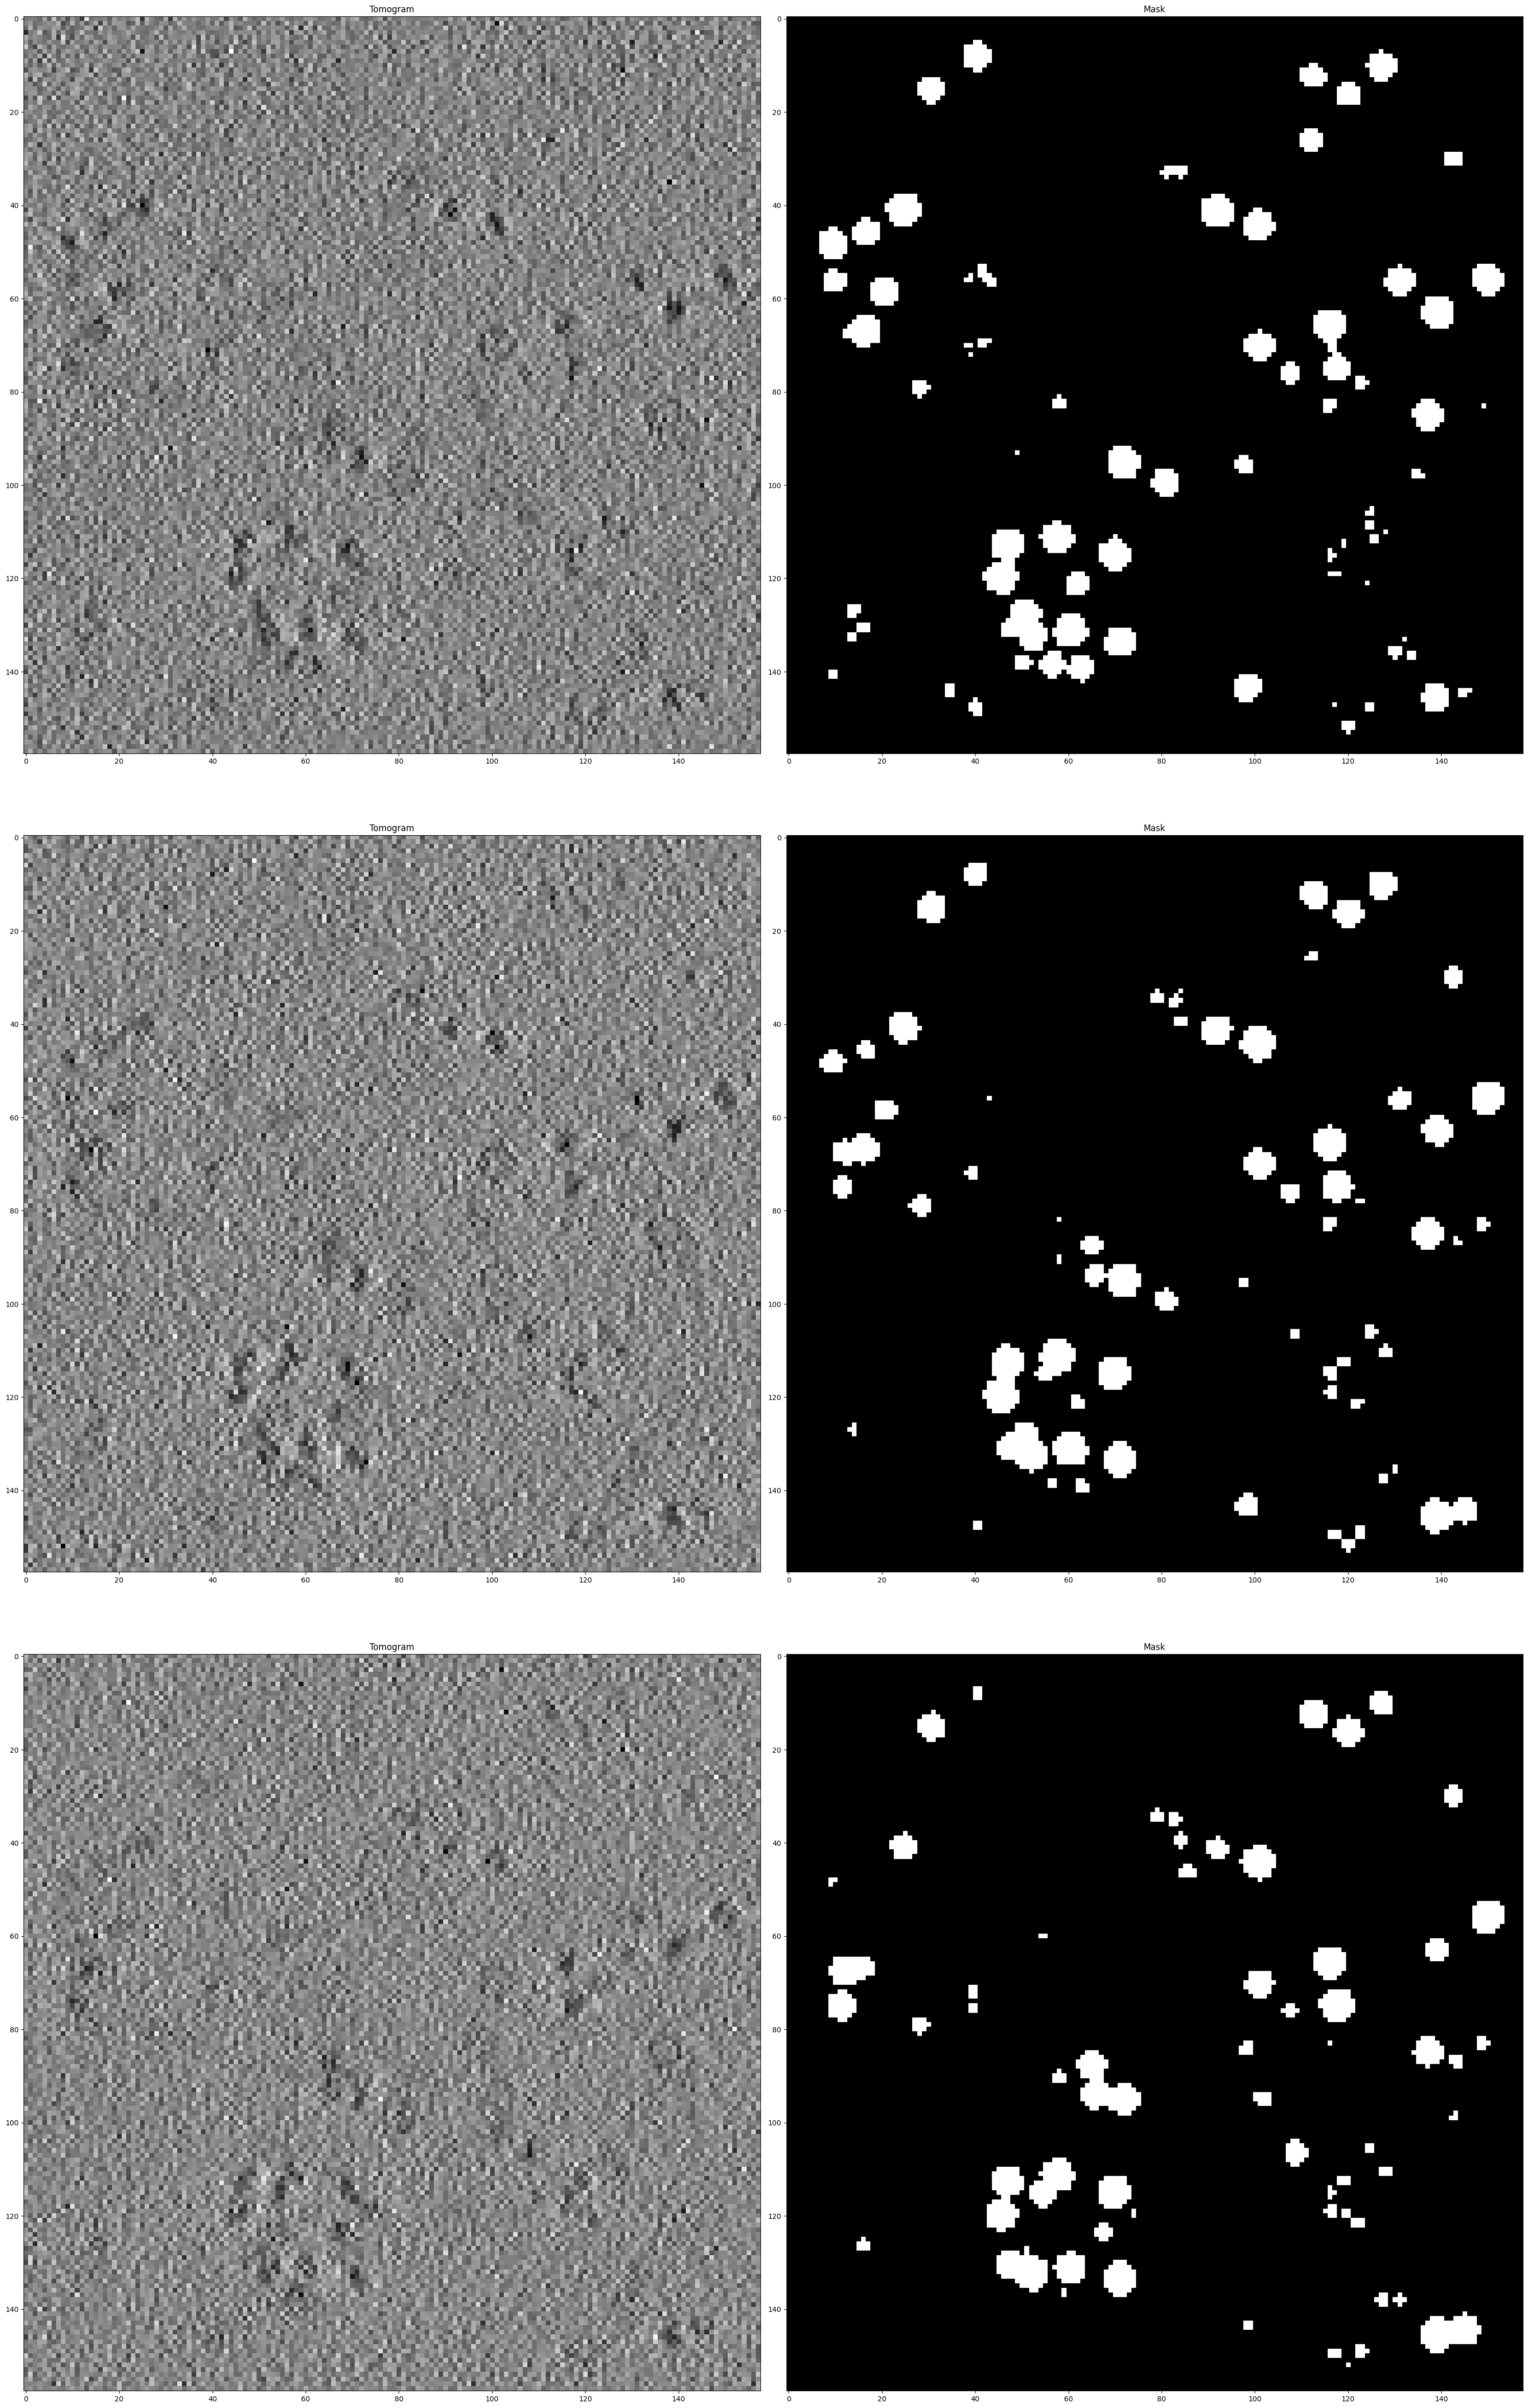

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 50))
for i in range(3):
    axes[i, 0].imshow(tomogram[27+i], cmap='gray')
    axes[i, 0].set_title("Tomogram")
    
    axes[i, 1].imshow(mask[27+i], cmap='gray')
    axes[i, 1].set_title("Mask")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()